In [1]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)

In [2]:
# Not actually sure which of all these we need...
# it's mostly copied from the importChemkin.py script.
# actually, from some old version that was lying around somewhere :-/
import os
import logging # doesn't work well in a notebook, without some fu
import rmgpy
import rmgpy.rmg
import rmgpy.rmg.input
#from rmgpy.display import display
from IPython.display import display
from rmgpy.chemkin import loadChemkinFile, readSpeciesBlock, readThermoBlock, readReactionsBlock, removeCommentFromLine
from rmgpy.data.thermo import Entry, saveEntry
from rmgpy.data.base import Entry as kinEntry
from rmgpy.data.kinetics.common import saveEntry as kinSaveEntry
from rmgpy.molecule import Molecule
from rmgpy.rmg.model import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius
from rmgpy.cantherm.output import prettify
from rmgpy.rmg.main import RMG, initializeLog
from rmgpy.molecule.draw import MoleculeDrawer

#import time
import sys
## Put the RMG-database project at the start of the python path, so we use that importOldDatabase script?
## (is this still needed?)
databaseDirectory = rmgpy.settings['database.directory']
databaseProjectDirectory = os.path.abspath(os.path.join(databaseDirectory, '..'))
sys.path.insert(0, databaseProjectDirectory)

In [3]:
logging.info("Loading RMG database...")
rmg = RMG()
rmg.outputDirectory = '.'
rmg.scratchDirectory = '.'
rmg.databaseDirectory = databaseDirectory
rmg.thermoLibraries = ['primaryThermoLibrary']
rmg.kineticsFamilies = ['H_Abstraction',]
rmg.reactionLibraries = [('KlippensteinH2O2', False),]
rmgpy.rmg.input.rmg = rmg  # put it in this scope so these functions can modify it
#rmg.loadDatabase()  # this seems to hang (forever??) but turns out it's not needed!
logging.info("Loaded database.")

In [4]:
rmg.reactionModel = rmgpy.rmg.model.CoreEdgeReactionModel()
rmg.reactionModel.kineticsEstimator = 'rate rules'
rmg.reactionModel.verboseComments = True
rmg.initialSpecies = []
rmg.reactionSystems = []

def makeOrEmptyDirectory(path):
    """Either create a directory at `path` or delete everything in it if it exists"""
    if os.path.exists(path):
        assert os.path.isdir(path), "Path {0} exists but is not a directory".format(path)
        # empty it out
        for root, dirs, files in os.walk(path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
    else:
        os.makedirs(path)
        

In [5]:
kineticsLibrary = rmgpy.data.kinetics.KineticsLibrary(
        label="AutoTST-M062X",
        name="AutoTST-M062X",
        solvent=None,
        shortDesc="AutoTST using M062X",
        longDesc="AutoTST calculations using M062X",
        )
def addReactionToKineticsLibrary(reaction):
    """
    Add the reaction (once species are identified) to the reactionLibrary
    """
    entry = kinEntry()
    entry.index = len(kineticsLibrary.entries) + 1
    entry.item = reaction
    entry.label = str(reaction)
    entry.data = reaction.kinetics
    comment = getattr(reaction, 'comment', '')
    if comment:
        entry.longDesc = comment + '.\n'
    else:
        entry.longDesc = ''
    entry.shortDesc = 'AutoTST M062X for {0}'.format(str(reaction))
    kineticsLibrary.entries[entry.index] = entry

def savePyKineticsLibrary(kineticsLibrary):
    "Save an RMG-Py style kinetics library"
    library_path = 'RMG-Py-kinetics-library'
    makeOrEmptyDirectory(library_path)
    kineticsLibrary.checkForDuplicates(markDuplicates=True)
    #kineticsLibrary.convertDuplicatesToMulti()
    kineticsLibrary.save(os.path.join(library_path, 'reactions.py'))
    kineticsLibrary.saveDictionary(os.path.join(library_path, 'dictionary.txt'))

    savedReactions = [kineticsLibrary.entries[key].item 
                      for key in sorted(kineticsLibrary.entries.keys())
                      ]


In [6]:
species_dict = {}

def kinetics(label, kinetics):
    reactants, products = label.split('_')
    reactants = reactants.split('+')
    products = products.split('+')

    reaction = Reaction(reactants=[], products=[], reversible=True)
    
    for in_list, out_list in [(reactants, reaction.reactants), (products, reaction.products)]:
        for i, smiles in enumerate(in_list):
            if smiles not in species_dict:
                species = Species().fromSMILES(smiles)
                species_dict[smiles] = species
                species.label = '{0}({1})'.format(species.toChemkin(), len(species_dict))
            out_list.append(species_dict[smiles])
    
    reaction.kinetics = kinetics
    print repr(reaction)
    display(reaction)
    
    addReactionToKineticsLibrary(reaction)
    

In [7]:
kinetics(
    label = 'C=CCC=C+[O]O_C=C[CH]C=C+OO',
    kinetics = Arrhenius(
        A = (1.46901e-07, 'cm^3/(mol*s)'),
        n = 5.46227,
        Ea = (16.0409, 'kJ/mol'),
        T0 = (1, 'K'),
        Tmin = (303.03, 'K'),
        Tmax = (2500, 'K'),
        comment = 'Fitted to 59 data points; dA = *|/ 2.40766, dn = +|- 0.115316, dEa = +|- 0.634353 kJ/mol',
    ),
)


Reaction(reactants=[Species(label="C5H8(1)", molecule=[Molecule(SMILES="C=CCC=C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7(3)", molecule=[Molecule(SMILES="C=C[CH]C=C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.46901e-07,'cm^3/(mol*s)'), n=5.46227, Ea=(16.0409,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.40766, dn = +|- 0.115316, dEa = +|- 0.634353 kJ/mol"""))


In [8]:
kineticsLibrary.entries

OrderedDict([(1,
              <Entry index=1 label="C5H8(1) + HO2(2) <=> C5H7(3) + H2O2(4)">)])

In [9]:
savePyKineticsLibrary(kineticsLibrary)

In [10]:
kineticsLibrary.entries.clear()

Next we paste in the results from the previous notebook. Uncomment the first line
```
%run filtered_kinetics.py
```

Reaction(reactants=[Species(label="C5H8(1)", molecule=[Molecule(SMILES="C=CCC=C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7(3)", molecule=[Molecule(SMILES="C=C[CH]C=C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.46901e-07,'cm^3/(mol*s)'), n=5.46227, Ea=(16.0409,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.40766, dn = +|- 0.115316, dEa = +|- 0.634353 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O2(5)", molecule=[Molecule(SMILES="COC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O2(6)", molecule=[Molecule(SMILES="CO[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000827612,'cm^3/(mol*s)'), n=4.50294, Ea=(56.3444,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33955, dn = +|- 0.0383657, dEa = +|- 0.21105 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(7)", molecule=[Molecule(SMILES="CCC=CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(8)", molecule=[Molecule(SMILES="C[CH]C=CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.56079e-07,'cm^3/(mol*s)'), n=5.22388, Ea=(11.9207,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.03086, dn = +|- 0.0929786, dEa = +|- 0.511476 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8(9)", molecule=[Molecule(SMILES="CC=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7(10)", molecule=[Molecule(SMILES="[CH2]C=CC")])], kinetics=Arrhenius(A=(1.85695e-08,'cm^3/(mol*s)'), n=5.63825, Ea=(24.6184,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.61249, dn = +|- 0.126031, dEa = +|- 0.693299 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(11)", molecule=[Molecule(SMILES="C=C(O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(12)", molecule=[Molecule(SMILES="C=C(O)[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.86399e-07,'cm^3/(mol*s)'), n=5.35115, Ea=(20.2957,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.17403, dn = +|- 0.10192, dEa = +|- 0.560659 kJ/mol"""))


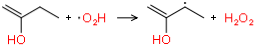

Reaction(reactants=[Species(label="C4H10(13)", molecule=[Molecule(SMILES="CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9(14)", molecule=[Molecule(SMILES="[CH2]CCC")])], kinetics=Arrhenius(A=(0.000948686,'cm^3/(mol*s)'), n=4.38662, Ea=(61.9582,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.26505, dn = +|- 0.0308561, dEa = +|- 0.16974 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8(15)", molecule=[Molecule(SMILES="C=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7(16)", molecule=[Molecule(SMILES="[CH2]CC=C")])], kinetics=Arrhenius(A=(0.000220412,'cm^3/(mol*s)'), n=4.48417, Ea=(61.2327,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.29944, dn = +|- 0.0343761, dEa = +|- 0.189103 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(18)", molecule=[Molecule(SMILES="C[CH]CC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000583326,'cm^3/(mol*s)'), n=4.35917, Ea=(44.6771,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.23402, dn = +|- 0.0275975, dEa = +|- 0.151814 kJ/mol"""))


Reaction(reactants=[Species(label="C6H8(19)", molecule=[Molecule(SMILES="C=C1C=CCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H7(20)", molecule=[Molecule(SMILES="C=C1[CH]CC=C1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.56034e-10,'cm^3/(mol*s)'), n=6.64499, Ea=(22.1924,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.61527, dn = +|- 0.126171, dEa = +|- 0.694065 kJ/mol"""))


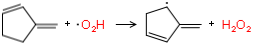

Reaction(reactants=[Species(label="C3H4O(21)", molecule=[Molecule(SMILES="C=CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O(22)", molecule=[Molecule(SMILES="C=C[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.37519e-05,'cm^3/(mol*s)'), n=5.0024, Ea=(30.7116,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.91102, dn = +|- 0.0849968, dEa = +|- 0.467568 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10(23)", molecule=[Molecule(SMILES="CC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9(24)", molecule=[Molecule(SMILES="C[C](C)C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00381462,'cm^3/(mol*s)'), n=4.38434, Ea=(39.5154,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2896, dn = +|- 0.0333792, dEa = +|- 0.183619 kJ/mol"""))


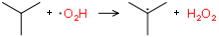

Reaction(reactants=[Species(label="C3H8(25)", molecule=[Molecule(SMILES="CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H7(26)", molecule=[Molecule(SMILES="C[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000337358,'cm^3/(mol*s)'), n=4.70263, Ea=(46.2109,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.40842, dn = +|- 0.0449463, dEa = +|- 0.24725 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O2(27)", molecule=[Molecule(SMILES="O=CCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O2(28)", molecule=[Molecule(SMILES="O=[C]CCO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000423229,'cm^3/(mol*s)'), n=4.33217, Ea=(10.9667,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33794, dn = +|- 0.038208, dEa = +|- 0.210182 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O2(29)", molecule=[Molecule(SMILES="O=CCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O2(30)", molecule=[Molecule(SMILES="O=[C]CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00108079,'cm^3/(mol*s)'), n=4.22914, Ea=(20.9665,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27527, dn = +|- 0.0319125, dEa = +|- 0.175551 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O(31)", molecule=[Molecule(SMILES="CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O(32)", molecule=[Molecule(SMILES="C[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000274848,'cm^3/(mol*s)'), n=4.67067, Ea=(21.5744,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.59853, dn = +|- 0.0615635, dEa = +|- 0.338661 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(33)", molecule=[Molecule(SMILES="CCC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(34)", molecule=[Molecule(SMILES="C[CH]C(C)O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000181889,'cm^3/(mol*s)'), n=4.60161, Ea=(54.0961,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.3787, dn = +|- 0.0421467, dEa = +|- 0.231849 kJ/mol"""))


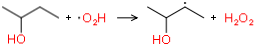

Reaction(reactants=[Species(label="C4H8O(35)", molecule=[Molecule(SMILES="CC(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(36)", molecule=[Molecule(SMILES="CC(C)[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000281069,'cm^3/(mol*s)'), n=4.5897, Ea=(15.2284,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.50747, dn = +|- 0.0538655, dEa = +|- 0.296314 kJ/mol"""))


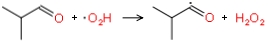

Reaction(reactants=[Species(label="C4H10O(33)", molecule=[Molecule(SMILES="CCC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(37)", molecule=[Molecule(SMILES="[CH2]C(O)CC")])], kinetics=Arrhenius(A=(0.00102796,'cm^3/(mol*s)'), n=4.40852, Ea=(62.869,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25438, dn = +|- 0.0297452, dEa = +|- 0.163628 kJ/mol"""))


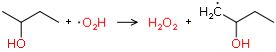

Reaction(reactants=[Species(label="C4H6O(38)", molecule=[Molecule(SMILES="C=C(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H5O(39)", molecule=[Molecule(SMILES="C=C(C)[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.22601e-05,'cm^3/(mol*s)'), n=4.98552, Ea=(32.7154,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.86223, dn = +|- 0.0816026, dEa = +|- 0.448896 kJ/mol"""))


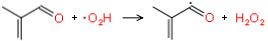

Reaction(reactants=[Species(label="C4H8O(35)", molecule=[Molecule(SMILES="CC(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(40)", molecule=[Molecule(SMILES="[CH2]C(C)C=O")])], kinetics=Arrhenius(A=(0.000383212,'cm^3/(mol*s)'), n=4.55507, Ea=(60.3052,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33514, dn = +|- 0.0379336, dEa = +|- 0.208673 kJ/mol"""))


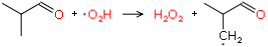

Reaction(reactants=[Species(label="C4H8(41)", molecule=[Molecule(SMILES="C=C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7(42)", molecule=[Molecule(SMILES="[CH2]C(=C)C")])], kinetics=Arrhenius(A=(1.05586e-07,'cm^3/(mol*s)'), n=5.54951, Ea=(27.2363,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.32581, dn = +|- 0.110777, dEa = +|- 0.609382 kJ/mol"""))


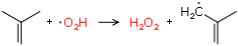

Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(44)", molecule=[Molecule(SMILES="[CH2]CCCO")])], kinetics=Arrhenius(A=(0.000740853,'cm^3/(mol*s)'), n=4.38311, Ea=(56.8389,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2143, dn = +|- 0.0254829, dEa = +|- 0.140181 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10(13)", molecule=[Molecule(SMILES="CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9(45)", molecule=[Molecule(SMILES="C[CH]CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00210652,'cm^3/(mol*s)'), n=4.45303, Ea=(49.819,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32839, dn = +|- 0.0372684, dEa = +|- 0.205013 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(46)", molecule=[Molecule(SMILES="CC=C(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(47)", molecule=[Molecule(SMILES="[CH2]C(O)=CC")])], kinetics=Arrhenius(A=(3.05514e-08,'cm^3/(mol*s)'), n=5.43438, Ea=(20.7556,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.21916, dn = +|- 0.104616, dEa = +|- 0.575492 kJ/mol"""))


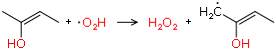

Reaction(reactants=[Species(label="C3H6(48)", molecule=[Molecule(SMILES="C=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H5(49)", molecule=[Molecule(SMILES="[CH2]C=C")])], kinetics=Arrhenius(A=(1.23038e-10,'cm^3/(mol*s)'), n=6.60553, Ea=(19.4098,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.5386, dn = +|- 0.122266, dEa = +|- 0.672585 kJ/mol"""))


Reaction(reactants=[Species(label="C2H6O(50)", molecule=[Molecule(SMILES="CCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H5O(51)", molecule=[Molecule(SMILES="[CH2]CO")])], kinetics=Arrhenius(A=(0.000409287,'cm^3/(mol*s)'), n=4.70424, Ea=(67.0893,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.42706, dn = +|- 0.0466716, dEa = +|- 0.256741 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(52)", molecule=[Molecule(SMILES="[CH2]CCC=O")])], kinetics=Arrhenius(A=(0.0059468,'cm^3/(mol*s)'), n=4.14413, Ea=(57.888,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.13258, dn = +|- 0.0163398, dEa = +|- 0.0898853 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8(15)", molecule=[Molecule(SMILES="C=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7(53)", molecule=[Molecule(SMILES="C=C[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(4.20615e-08,'cm^3/(mol*s)'), n=5.62053, Ea=(19.7262,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.56265, dn = +|- 0.123503, dEa = +|- 0.679391 kJ/mol"""))


Reaction(reactants=[Species(label="C6H8(54)", molecule=[Molecule(SMILES="C=C1CC=CC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H7(55)", molecule=[Molecule(SMILES="C=C1[CH]C=CC1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.01875e-07,'cm^3/(mol*s)'), n=5.07549, Ea=(10.2176,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.93084, dn = +|- 0.0863504, dEa = +|- 0.475014 kJ/mol"""))


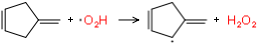

Reaction(reactants=[Species(label="C4H10O(56)", molecule=[Molecule(SMILES="CC(C)(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(57)", molecule=[Molecule(SMILES="[CH2]C(C)(C)O")])], kinetics=Arrhenius(A=(0.0142764,'cm^3/(mol*s)'), n=4.09233, Ea=(66.0716,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.12286, dn = +|- 0.015208, dEa = +|- 0.0836592 kJ/mol"""))


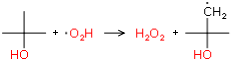

Reaction(reactants=[Species(label="C6H8(58)", molecule=[Molecule(SMILES="C1C=CCCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H7(59)", molecule=[Molecule(SMILES="[CH]1C=CC=CC1")])], kinetics=Arrhenius(A=(2.81635e-06,'cm^3/(mol*s)'), n=5.07119, Ea=(13.2806,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.95305, dn = +|- 0.0878515, dEa = +|- 0.483272 kJ/mol"""))


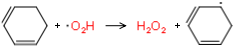

Reaction(reactants=[Species(label="C2H6O(50)", molecule=[Molecule(SMILES="CCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H5O(60)", molecule=[Molecule(SMILES="C[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000564314,'cm^3/(mol*s)'), n=4.34123, Ea=(31.9151,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28242, dn = +|- 0.0326461, dEa = +|- 0.179587 kJ/mol"""))


Reaction(reactants=[Species(label="C3H8(25)", molecule=[Molecule(SMILES="CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H7(61)", molecule=[Molecule(SMILES="[CH2]CC")])], kinetics=Arrhenius(A=(0.000510827,'cm^3/(mol*s)'), n=4.59277, Ea=(58.4923,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32453, dn = +|- 0.0368865, dEa = +|- 0.202913 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(62)", molecule=[Molecule(SMILES="CCC[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000166121,'cm^3/(mol*s)'), n=4.53539, Ea=(32.6901,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36841, dn = +|- 0.0411636, dEa = +|- 0.226441 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(63)", molecule=[Molecule(SMILES="CCC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(7.91164e-05,'cm^3/(mol*s)'), n=4.59616, Ea=(16.6055,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.52125, dn = +|- 0.0550603, dEa = +|- 0.302887 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O(64)", molecule=[Molecule(SMILES="CC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H5O(65)", molecule=[Molecule(SMILES="[CH2]C(C)=O")])], kinetics=Arrhenius(A=(3.89078e-06,'cm^3/(mol*s)'), n=4.90542, Ea=(44.584,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.61705, dn = +|- 0.0630746, dEa = +|- 0.346973 kJ/mol"""))


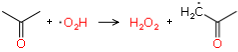

Reaction(reactants=[Species(label="C2H6O(66)", molecule=[Molecule(SMILES="COC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H5O(67)", molecule=[Molecule(SMILES="[CH2]OC")])], kinetics=Arrhenius(A=(0.00107875,'cm^3/(mol*s)'), n=4.37156, Ea=(38.6209,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.26938, dn = +|- 0.0313052, dEa = +|- 0.17221 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(68)", molecule=[Molecule(SMILES="CCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(69)", molecule=[Molecule(SMILES="C[CH]C(C)=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.10146e-06,'cm^3/(mol*s)'), n=5.12066, Ea=(31.0702,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.82321, dn = +|- 0.0788229, dEa = +|- 0.433605 kJ/mol"""))


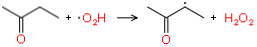

Reaction(reactants=[Species(label="C2H4O(70)", molecule=[Molecule(SMILES="C1CO1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H3O(71)", molecule=[Molecule(SMILES="[CH]1CO1")])], kinetics=Arrhenius(A=(0.102149,'cm^3/(mol*s)'), n=3.87668, Ea=(70.1773,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.07587, dn = +|- 0.00959792, dEa = +|- 0.0527982 kJ/mol"""))


Reaction(reactants=[Species(label="C5H6(72)", molecule=[Molecule(SMILES="C1C=CCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H5(73)", molecule=[Molecule(SMILES="[CH]1C=CC=C1")])], kinetics=Arrhenius(A=(2.75415e-08,'cm^3/(mol*s)'), n=5.57639, Ea=(16.934,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.51401, dn = +|- 0.120988, dEa = +|- 0.665557 kJ/mol"""))


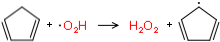

Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(74)", molecule=[Molecule(SMILES="CC[CH]C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.70895e-08,'cm^3/(mol*s)'), n=5.53146, Ea=(26.0936,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.42086, dn = +|- 0.116033, dEa = +|- 0.638298 kJ/mol"""))


Reaction(reactants=[Species(label="C2H6(75)", molecule=[Molecule(SMILES="CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H5(76)", molecule=[Molecule(SMILES="C[CH2]")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00107611,'cm^3/(mol*s)'), n=4.64503, Ea=(58.9259,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.37643, dn = +|- 0.0419307, dEa = +|- 0.230661 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O2(5)", molecule=[Molecule(SMILES="COC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H3O2(77)", molecule=[Molecule(SMILES="[CH2]OC=O")])], kinetics=Arrhenius(A=(0.000104186,'cm^3/(mol*s)'), n=4.50983, Ea=(53.7734,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.315, dn = +|- 0.0359384, dEa = +|- 0.197697 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(33)", molecule=[Molecule(SMILES="CCC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(78)", molecule=[Molecule(SMILES="[CH2]CC(C)O")])], kinetics=Arrhenius(A=(9.523e-05,'cm^3/(mol*s)'), n=4.57604, Ea=(61.4648,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.37128, dn = +|- 0.0414389, dEa = +|- 0.227956 kJ/mol"""))


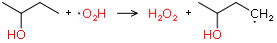

Reaction(reactants=[Species(label="C4H6O(79)", molecule=[Molecule(SMILES="CC=CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H5O(80)", molecule=[Molecule(SMILES="CC=C[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.63673e-05,'cm^3/(mol*s)'), n=4.91506, Ea=(23.471,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.76652, dn = +|- 0.0746773, dEa = +|- 0.4108 kJ/mol"""))


Reaction(reactants=[Species(label="C6H8(19)", molecule=[Molecule(SMILES="C=C1C=CCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H7(81)", molecule=[Molecule(SMILES="C=C1C=C[CH]C1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(3.96701e-10,'cm^3/(mol*s)'), n=6.4638, Ea=(13.0827,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.31164, dn = +|- 0.109974, dEa = +|- 0.604968 kJ/mol"""))


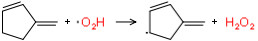

Reaction(reactants=[Species(label="C4H8O(68)", molecule=[Molecule(SMILES="CCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(82)", molecule=[Molecule(SMILES="[CH2]C(=O)CC")])], kinetics=Arrhenius(A=(8.05561e-07,'cm^3/(mol*s)'), n=5.00571, Ea=(50.7329,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.73253, dn = +|- 0.0721277, dEa = +|- 0.396774 kJ/mol"""))


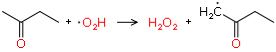

Reaction(reactants=[Species(label="C3H6O(83)", molecule=[Molecule(SMILES="CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O(84)", molecule=[Molecule(SMILES="CC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000293965,'cm^3/(mol*s)'), n=4.67279, Ea=(13.2914,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.50013, dn = +|- 0.0532249, dEa = +|- 0.29279 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10(23)", molecule=[Molecule(SMILES="CC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9(85)", molecule=[Molecule(SMILES="[CH2]C(C)C")])], kinetics=Arrhenius(A=(0.000832921,'cm^3/(mol*s)'), n=4.41042, Ea=(60.4783,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25863, dn = +|- 0.0301881, dEa = +|- 0.166065 kJ/mol"""))


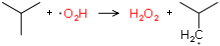

Reaction(reactants=[Species(label="C4H10O(86)", molecule=[Molecule(SMILES="CC(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(87)", molecule=[Molecule(SMILES="[CH2]C(C)CO")])], kinetics=Arrhenius(A=(0.001262,'cm^3/(mol*s)'), n=4.35918, Ea=(59.5366,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22938, dn = +|- 0.0271023, dEa = +|- 0.14909 kJ/mol"""))


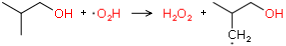

Reaction(reactants=[Species(label="CH4O(88)", molecule=[Molecule(SMILES="CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="CH3O(89)", molecule=[Molecule(SMILES="[CH2]O")])], kinetics=Arrhenius(A=(8.64717e-05,'cm^3/(mol*s)'), n=4.75283, Ea=(41.0765,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.49505, dn = +|- 0.0527799, dEa = +|- 0.290342 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(90)", molecule=[Molecule(SMILES="C[CH]CCO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000375686,'cm^3/(mol*s)'), n=4.61727, Ea=(47.4469,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.3677, dn = +|- 0.0410955, dEa = +|- 0.226066 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(86)", molecule=[Molecule(SMILES="CC(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(91)", molecule=[Molecule(SMILES="CC(C)[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000391488,'cm^3/(mol*s)'), n=4.50526, Ea=(36.07,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36394, dn = +|- 0.0407347, dEa = +|- 0.224082 kJ/mol"""))


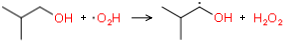

Reaction(reactants=[Species(label="C4H8O(68)", molecule=[Molecule(SMILES="CCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(92)", molecule=[Molecule(SMILES="[CH2]CC(C)=O")])], kinetics=Arrhenius(A=(0.000631728,'cm^3/(mol*s)'), n=4.64055, Ea=(66.8149,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.40113, dn = +|- 0.0442652, dEa = +|- 0.243503 kJ/mol"""))


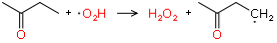

Reaction(reactants=[Species(label="C5H8(93)", molecule=[Molecule(SMILES="C=CC=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7(94)", molecule=[Molecule(SMILES="[CH2]C=CC=C")])], kinetics=Arrhenius(A=(4.0144e-10,'cm^3/(mol*s)'), n=6.30656, Ea=(24.2759,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 3.91317, dn = +|- 0.179058, dEa = +|- 0.985 kJ/mol"""))


Reaction(reactants=[Species(label="CH2O(95)", molecule=[Molecule(SMILES="C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="CHO(96)", molecule=[Molecule(SMILES="[CH]=O")])], kinetics=Arrhenius(A=(4.23547e-06,'cm^3/(mol*s)'), n=5.20393, Ea=(21.3195,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.04626, dn = +|- 0.0939706, dEa = +|- 0.516933 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(97)", molecule=[Molecule(SMILES="CC[CH]CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.0157366,'cm^3/(mol*s)'), n=3.87722, Ea=(45.4966,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06497, dn = +|- 0.00826126, dEa = +|- 0.0454452 kJ/mol"""))


Reaction(reactants=[Species(label="C3H4(98)", molecule=[Molecule(SMILES="C#CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3(99)", molecule=[Molecule(SMILES="C#C[CH2]")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(9.02065e-08,'cm^3/(mol*s)'), n=5.56952, Ea=(34.8886,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.33181, dn = +|- 0.111115, dEa = +|- 0.611241 kJ/mol"""))


Reaction(reactants=[Species(label="CH4O2(100)", molecule=[Molecule(SMILES="COO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="CH3O2(101)", molecule=[Molecule(SMILES="CO[O]")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.25347e-05,'cm^3/(mol*s)'), n=4.61955, Ea=(0.462874,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.41572, dn = +|- 0.045624, dEa = +|- 0.250978 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(102)", molecule=[Molecule(SMILES="C=C(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(103)", molecule=[Molecule(SMILES="[CH2]C(=C)CO")])], kinetics=Arrhenius(A=(8.37166e-09,'cm^3/(mol*s)'), n=5.75426, Ea=(31.1394,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.74682, dn = +|- 0.132612, dEa = +|- 0.729496 kJ/mol"""))


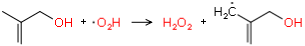

In [11]:
%run -i filtered_kinetics.py

In [12]:
savePyKineticsLibrary(kineticsLibrary)